## Generating Pixels One by One: Your First Autoregressive Image Generation Model

Welcome, I am glad you are here!

I'm [Tuna](https://tunahansalih.github.io). My world is pretty much all about image and video generation. It is what I focus on in my PhD and during my internships at places like Adobe (working on Firefly!) and Amazon AGI. For a while, I have been working with diffusion-based models, they are incredibly powerful.

But the landscape of generative modeling is always growing, and I want to explore other types of generative models. Right now, I am diving into autoregressive models. I always find the best way to learn a topic is by trying to teach it to others. So, this blog post series is an attempt to teach myself the basics of autoregressive models, hoping you can learn something from it, too. I'll start with the basics and try to understand how these models work piece by piece.

So, if you are curious about this side of the generative AI, let's get started and see how to generate images pixel by pixel!

## What Makes a Model "Autoregressive"?

Alright, "Autoregressive". Let's break it down with some mathematical intuition!

You have already seen "auto-regressive" models in action even if you didn't call them that. At its heart, it basically means predicting the next outcome based on all the things that came before it.

Think about how you type on your phone. When you write "the weather is ...", the keyboard will suggest completions based on the words you entered such as "sunny", "rainy", "perfect for AI research" (maybe not that last one). That's an auto-regressive model in action for language!

**Mathematically**, for a sequence \(x_1, x_2, ..., x_T\), an autoregressive model learns:

$$
P(x_1, x_2, ..., x_T) = P(x_1) \cdot P(x_2|x_1) \cdot P(x_3|x_1, x_2) \cdot ... \cdot P(x_T|x_1, ..., x_{T-1})
$$

This is just the **chain rule of probability**! Each new element depends on all the previous ones.

For images, we can think of each pixel as an element in our sequence. So instead of predicting the next word, we're predicting the next pixel value based on all the pixels we've seen so far. Cool, right?

## Let's Start with Data: Meet Our MNIST Friends

Before we dive into the math, let's get acquainted with our data. We'll use MNIST digits - they're simple, well-understood, and good for learning the basics.

Image batch shape: torch.Size([100, 28, 28])
Individual image shape: torch.Size([28, 28])
Pixel value range: [0, 255]


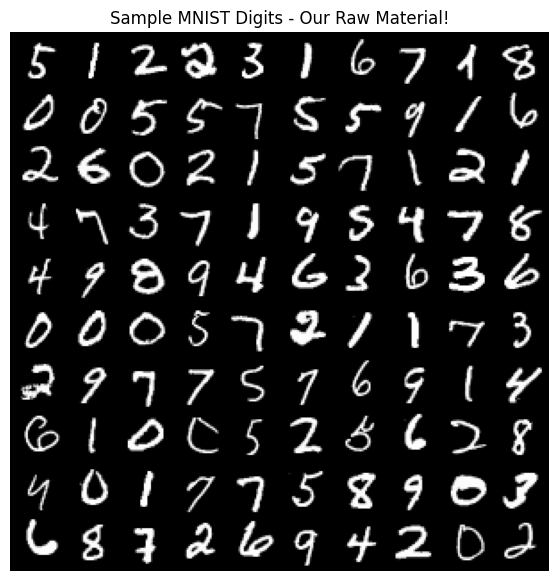

In [1]:
import random
import torchvision
import matplotlib.pyplot as plt

# Load and visualize some MNIST data
mnist = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=torchvision.transforms.ToTensor())

# Get 100 random image indices
rand_indices = random.sample(range(len(mnist.data)), 100)

# Get the images
images = mnist.data[rand_indices]

print(f"Image batch shape: {images.shape}")
print(f"Individual image shape: {images[0].shape}")
print(f"Pixel value range: [{images.min()}, {images.max()}]")

# Create a nice grid to visualize
grid = torchvision.utils.make_grid(images.unsqueeze(1), nrow=10) # Add channel dimension

# Plot the grid
plt.figure(figsize=(7, 7))
plt.imshow(grid.permute(1, 2, 0), cmap='gray')  # Permute to (H, W, C) format
plt.axis('off')
plt.title("Sample MNIST Digits - Our Raw Material!")
plt.show()

## The "Pixel as Token" Approach: Quantizing Intensities

We treat image generation more like language modeling. Each pixel's intensity will be *quantized* into one of a discrete number of bins. Each bin then gets an integer label, turning our pixels into "tokens" or "words" from a fixed vocabulary.

### 1. Quantization:

- We take the continuous grayscale pixel values (0.0 to 1.0).
- We divide this range into `K` discrete bins (e.g., `K=16` or `K=256`).
- Each pixel's original intensity is mapped to the integer label of the bin it falls into.
- Example: If `K=4`, intensities 0.0-0.25 map to token 0, 0.25-0.5 to token 1, etc.

### 2. Prediction as Classification:

- The model's task is now to predict the **integer label** (token) of the next pixel, given the tokens of previous pixels.
- This is a **K-class classification problem** for each pixel.

**Benefits:**

- Allows using powerful classification machinery (like Cross-Entropy loss).
- Can be combined with techniques like embedding layers for tokens, similar to NLP.

**Trade-offs:**

- **Information Loss:** Quantization inherently loses some precision from the original grayscale values. More bins reduce this loss but increase model complexity.
- **Vocabulary Size:** The number of bins (`K`) becomes our vocabulary size.

Quantized images batch shape: torch.Size([32, 1, 28, 28])
Data type of quantized images: torch.int64
Unique integer labels in a sample quantized image: tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15])
Min/Max integer labels: [0, 15]


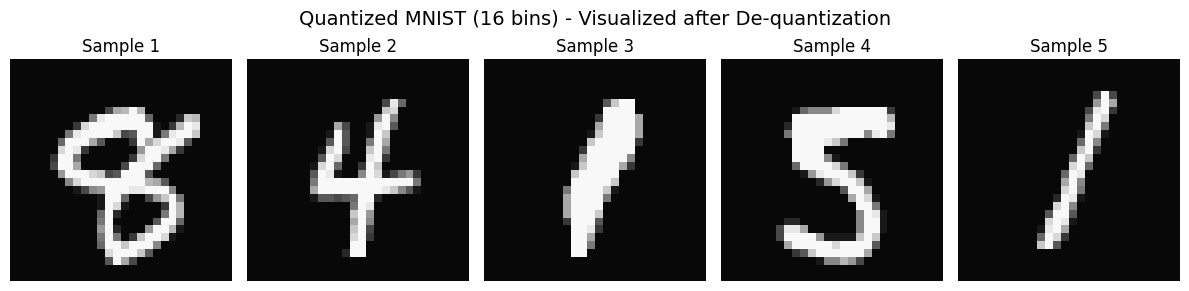


Examining Quantized Pixel Integer Labels (0-15)

Patch of integer labels (quantized):
[[10  5  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  0  4]
 [13 12  4  5 15]]

Same patch, de-quantized for visualization (approx. grayscale):
[[0.65625 0.34375 0.03125 0.03125 0.03125]
 [0.03125 0.03125 0.03125 0.03125 0.03125]
 [0.03125 0.03125 0.03125 0.03125 0.03125]
 [0.03125 0.03125 0.03125 0.03125 0.28125]
 [0.84375 0.78125 0.28125 0.34375 0.96875]]

This confirms we are working with integer token labels from 0 to 15.


In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

# --- Hyperparameters ---
BATCH_SIZE = 32
IMG_SIZE = 28
N_PIXELS = IMG_SIZE * IMG_SIZE
CONTEXT_LENGTH = 10 

# --- Quantization Settings ---
NUM_QUANTIZATION_BINS = 16  # K: Our pixel vocabulary size. Start with a smaller K. Max is 256 for 8-bit.
# START_TOKEN_VALUE_INT will be an integer now, e.g., NUM_QUANTIZATION_BINS (if labels are 0 to K-1)
START_TOKEN_VALUE_INT = NUM_QUANTIZATION_BINS 

# --- Data Loading and Quantization ---
def quantize_tensor(tensor_image, num_bins):
    """Quantizes a tensor image (values 0-1) into num_bins integer labels (0 to num_bins-1)."""
    # Scale to [0, num_bins - epsilon] then floor to get integer labels
    # tensor_image is already in [0,1]
    scaled_image = tensor_image * (num_bins - 1e-6) # Subtract epsilon to handle 1.0 correctly
    quantized_image = torch.floor(scaled_image).long() #.long() for integer labels
    return quantized_image

# Transform pipeline
transform_quantize = transforms.Compose([
    transforms.ToTensor(), # Converts to [0,1] float tensor
    transforms.Lambda(lambda x: quantize_tensor(x, NUM_QUANTIZATION_BINS)) # Quantize to integer labels
])

# MNIST dataset
trainset_quantized = torchvision.datasets.MNIST(root='./data', train=True,
                                                 download=True, transform=transform_quantize)
# 
trainloader_quantized = torch.utils.data.DataLoader(trainset_quantized, batch_size=BATCH_SIZE,
                                                   shuffle=True)

# --- Visualize Quantized Data ---

# Helper to de-quantize for visualization
def dequantize_tensor(quantized_image_labels, num_bins):
    """Converts integer labels back to approximate normalized grayscale values (centers of bins)."""
    # Map label L to (L + 0.5) / num_bins
    return (quantized_image_labels.float() + 0.5) / num_bins

# Fetch a batch of quantized images
sample_quantized_batch, _ = next(iter(trainloader_quantized))
quantized_images_int = sample_quantized_batch

print(f"Quantized images batch shape: {quantized_images_int.shape}")
print(f"Data type of quantized images: {quantized_images_int.dtype}")
print(f"Unique integer labels in a sample quantized image: {torch.unique(quantized_images_int[0])}")
print(f"Min/Max integer labels: [{quantized_images_int.min()}, {quantized_images_int.max()}]")

# De-quantize for visualization
vis_images_dequantized = dequantize_tensor(quantized_images_int, NUM_QUANTIZATION_BINS)

fig, axes = plt.subplots(1, 5, figsize=(12, 3))
fig.suptitle(f"Quantized MNIST ({NUM_QUANTIZATION_BINS} bins) - Visualized after De-quantization", fontsize=14)

for i in range(5):
    axes[i].imshow(vis_images_dequantized[i].squeeze(), cmap='gray', vmin=0, vmax=1)
    axes[i].set_title(f"Sample {i+1}")
    axes[i].axis('off')

plt.tight_layout()
plt.show()

# Examine a patch of integer labels
print("\n" + "="*60)
print(f"Examining Quantized Pixel Integer Labels (0-{NUM_QUANTIZATION_BINS-1})")
print("="*60)

img_patch_int_labels = quantized_images_int[0].squeeze()[10:15, 10:15]  # 5x5 patch of integer labels
print(f"\nPatch of integer labels (quantized):")
print(img_patch_int_labels.numpy())

# For comparison, show the de-quantized version of the same patch
img_patch_dequantized_vis = dequantize_tensor(img_patch_int_labels, NUM_QUANTIZATION_BINS)
print(f"\nSame patch, de-quantized for visualization (approx. grayscale):")
print(img_patch_dequantized_vis.numpy())
print(f"\nThis confirms we are working with integer token labels from 0 to {NUM_QUANTIZATION_BINS-1}.")

## The Heart of Autoregression: Context Windows

Now for the fun part! How do we actually implement "predicting the next pixel based on previous pixels"?

The key insight is *context windows*. Instead of using *all* previous pixels, we use a *sliding window* of the last `k` pixels as our context.

*Mathematically*, instead of modeling \(P(x_i | x_1, x_2, ..., x_{i-1})\), we approximate it as:

$$P(x_i | x_{i-1}, x_{i-2}, ..., x_{i-k})$$

This is called a *k-th order Markov assumption* - we assume the immediate past is most informative for predicting the future.

*But wait!* What about the first few pixels that don't have enough history? That's where our **start tokens** come in - they're like saying "this is the beginning of an image" to our model.

## Building Our Neural Network: Predicting Pixel Tokens

Our neural network will now predict a *distribution over the possible pixel tokens (integer labels)* for the next pixel.

In [3]:
import torch.nn as nn
import torch.nn.functional as F

class CategoricalPixelPredictor(nn.Module):
    def __init__(self, vocab_size, embedding_dim, context_length, hidden_size):
        """
        Args:
            vocab_size (int): NUM_QUANTIZATION_BINS + 1 (for the start token)
            embedding_dim (int): Dimension for the learned token embeddings.
            context_length (int): CONTEXT_LENGTH - number of previous tokens to consider.
            hidden_size (int): Size of the hidden layers.
        """
        super(CategoricalPixelPredictor, self).__init__()
        # Embedding dimension
        self.embedding_dim = embedding_dim
        # Context length
        self.context_length = context_length
        # Vocabulary size
        self.num_pixel_values = vocab_size -1 # This is K, e.g., 16

        # Embedding layer: vocab_size includes the start token
        self.embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=embedding_dim)

        # Absolute position embeddings for the entire image
        self.abs_pos_row_embedding = nn.Parameter(torch.randn(IMG_SIZE, embedding_dim))
        self.abs_pos_col_embedding = nn.Parameter(torch.randn(IMG_SIZE, embedding_dim))

        # Input to fc1 is context_length * embedding_dim because we flatten the embeddings
        self.fc1 = nn.Linear(context_length * embedding_dim + 2 * embedding_dim, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.dropout = nn.Dropout(0.25)
        # Output layer: predicts logits for each of the K pixel values (not including start token)
        self.fc_out = nn.Linear(hidden_size, self.num_pixel_values) 

    def forward(self, x_tokens, positions=None, training=True):
        """
        Args:
            x_tokens (Tensor): Batch of context windows. Shape: [batch_size, CONTEXT_LENGTH]. Values are integer tokens.
        """
        batch_size = x_tokens.shape[0]

        if positions is None:
            positions = torch.arange(batch_size, device=x_tokens.device) % (self.img_size * self.img_size)

        rows = positions // self.img_size
        cols = positions % self.img_size

        # Get absolute position embeddings
        row_embeddings = self.abs_pos_row_embedding[rows]  # [batch_size, embedding_dim]
        col_embeddings = self.abs_pos_col_embedding[cols]  # [batch_size, embedding_dim]
        
        # x_tokens are integer labels, including the START_TOKEN_VALUE_INT for padding/start
        # Expected values in x_tokens: 0 to NUM_QUANTIZATION_BINS (inclusive)
        embedded_context = self.embedding(x_tokens)  # Shape: [batch_size, CONTEXT_LENGTH, embedding_dim]
        
        # Flatten the embeddings from the context window
        flattened_context = embedded_context.view(batch_size, -1) # Shape: [batch_size, CONTEXT_LENGTH * embedding_dim]
        combined_embeddings = torch.cat([
            flattened_context,
            row_embeddings,
            col_embeddings
        ], dim=1)
        
        h = F.relu(self.fc1(combined_embeddings))
        if training:
            h = self.dropout(h)
        h = F.relu(self.fc2(h))
        if training:
            h = self.dropout(h)
        
        # Output raw logits for each of the K possible pixel values
        output_logits = self.fc_out(h) # Shape: [batch_size, NUM_QUANTIZATION_BINS]
        return output_logits

# --- Model Initialization ---
EMBEDDING_DIM = 32 # Dimension for pixel token embeddings
HIDDEN_SIZE = 256

# vocab_size for embedding layer needs to include our special START_TOKEN_VALUE_INT
# If pixel tokens are 0..15 (K=16), and start token is 16, vocab_size is 17.
model_vocab_size = NUM_QUANTIZATION_BINS + 1 

model = CategoricalPixelPredictor(
    vocab_size=model_vocab_size, 
    embedding_dim=EMBEDDING_DIM, 
    context_length=CONTEXT_LENGTH, 
    hidden_size=HIDDEN_SIZE
)

print(f"Model: {model.__class__.__name__}")
print(f"  Pixel Vocabulary Size (K for output classes): {NUM_QUANTIZATION_BINS}")
print(f"  Embedding Vocabulary Size (K + start_token): {model_vocab_size}")
print(f"  Embedding Dimension: {EMBEDDING_DIM}")
print(f"  Context Length: {CONTEXT_LENGTH}")
print(f"  Hidden Size: {HIDDEN_SIZE}")
print(f"  Model parameters: {sum(p.numel() for p in model.parameters()):,}")

Model: CategoricalPixelPredictor
  Pixel Vocabulary Size (K for output classes): 16
  Embedding Vocabulary Size (K + start_token): 17
  Embedding Dimension: 32
  Context Length: 10
  Hidden Size: 256
  Model parameters: 170,800


In [4]:
def create_randomized_token_training_data(dataloader_quantized, context_length, start_token_int, num_pixel_values, max_samples=100000):
    """
    Create properly randomized training data (context tokens, target token) 
    for autoregressive pixel token prediction.
    
    Args:
        dataloader_quantized: PyTorch DataLoader for the quantized dataset (yields integer token images).
        context_length (int): Size of context window.
        start_token_int (int): Integer value for the start/padding token (e.g., NUM_QUANTIZATION_BINS).
        num_pixel_values (int): The number of actual pixel values (K, e.g., NUM_QUANTIZATION_BINS).
                                  Target tokens will be in the range [0, num_pixel_values - 1].
        max_samples (int): Maximum number of training pairs to generate.
    
    Returns:
        contexts (Tensor): [N_SAMPLES, context_length] of integer tokens.
        targets (Tensor): [N_SAMPLES] of integer target tokens (0 to K-1).
    """
    all_contexts = []
    all_targets = [] # Target will be a single integer token index
    samples_collected = 0
    
    print(f"Generating randomized training data with integer tokens (max {max_samples:,} samples)...")
    print(f"Contexts will use tokens 0-{num_pixel_values-1} and start_token={start_token_int}.")
    print(f"Targets will be tokens 0-{num_pixel_values-1}.")

    for batch_idx, (quantized_images, _) in enumerate(dataloader_quantized):
        if samples_collected >= max_samples:
            break
        
        # quantized_images are already integer tokens [0, K-1]
        flat_token_images = quantized_images.view(quantized_images.size(0), -1)  # [batch_size, N_PIXELS]
        batch_size_curr, n_pixels = flat_token_images.shape
        
        for img_idx in range(batch_size_curr):
            if samples_collected >= max_samples:
                break
            
            single_token_image = flat_token_images[img_idx] # Shape [N_PIXELS], values 0 to K-1
            
            # Create padded sequence for context building: [START, START, ..., token_0, token_1, ...]
            # The `start_token_int` is used for padding here.
            padded_token_sequence = torch.cat([
                torch.full((context_length,), start_token_int, dtype=torch.long),
                single_token_image # These are already .long() from quantize_tensor
            ]) # Shape: [context_length + N_PIXELS]
            
            for pixel_idx in range(n_pixels): # For each actual pixel token we want to predict
                if samples_collected >= max_samples:
                    break
                
                # Context is window from padded_token_sequence
                context = padded_token_sequence[pixel_idx : pixel_idx + context_length] # Shape [context_length]
                
                # Target is the actual pixel token from the original (unpadded) sequence
                target_token = single_token_image[pixel_idx] # Shape [], a single integer token (0 to K-1)
                
                all_contexts.append(context)
                all_targets.append(target_token.unsqueeze(0)) # Make it [1]
                samples_collected += 1
        
        if batch_idx % 50 == 0 and batch_idx > 0:
            print(f"  Processed {batch_idx} batches, collected {samples_collected} samples...")
    
    contexts_tensor = torch.stack(all_contexts).long() # Ensure .long() for embedding lookup
    targets_tensor = torch.cat(all_targets).long()     # Ensure .long() for CrossEntropyLoss
    
    # Shuffle
    indices = torch.randperm(len(contexts_tensor))
    contexts_tensor = contexts_tensor[indices]
    targets_tensor = targets_tensor[indices]
    
    print(f"Generated {len(contexts_tensor):,} randomized token training pairs.")
    print(f"Contexts shape: {contexts_tensor.shape}, dtype: {contexts_tensor.dtype}")
    print(f"Targets shape: {targets_tensor.shape}, dtype: {targets_tensor.dtype}")
    print(f"Sample context tokens: {contexts_tensor[0]}")
    print(f"Sample target token: {targets_tensor[0]}")
    print(f"Unique values in targets: {torch.unique(targets_tensor)}")
    assert targets_tensor.max() < num_pixel_values, "Target tokens should be less than num_pixel_values (K)"
    assert targets_tensor.min() >= 0, "Target tokens should be non-negative"
    
    return contexts_tensor, targets_tensor

# Generate our token-based training data
# Pass trainloader_quantized and START_TOKEN_VALUE_INT
# num_pixel_values is NUM_QUANTIZATION_BINS (K)
train_contexts_tok, train_targets_tok = create_randomized_token_training_data(
    trainloader_quantized, 
    CONTEXT_LENGTH, 
    START_TOKEN_VALUE_INT, 
    NUM_QUANTIZATION_BINS, # This is K, number of actual pixel values (0 to K-1)
    max_samples=200000 # Might need more samples for token-based models
)

# For clarity in later cells, let's rename them to what the training loop expects
# though this is not strictly necessary if we update the training loop variable names.
train_contexts = train_contexts_tok
train_targets = train_targets_tok

Generating randomized training data with integer tokens (max 200,000 samples)...
Contexts will use tokens 0-15 and start_token=16.
Targets will be tokens 0-15.
Generated 200,000 randomized token training pairs.
Contexts shape: torch.Size([200000, 10]), dtype: torch.int64
Targets shape: torch.Size([200000]), dtype: torch.int64
Sample context tokens: tensor([2, 0, 0, 0, 0, 0, 0, 0, 0, 0])
Sample target token: 0
Unique values in targets: tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15])


In [5]:
import torch.optim as optim
from tqdm.auto import tqdm

# --- Training Configuration ---
LEARNING_RATE = 0.001 # May need adjustment for categorical model
EPOCHS = 15  # Increased epochs, as token prediction can be harder
BATCH_SIZE_TRAIN = 512

# --- Device Setup ---
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(f"Using device: {device}")

# --- Model, Data, Loss, Optimizer ---
# Model (CategoricalPixelPredictor) is already initialized from the previous cell.
# train_contexts (token sequences) and train_targets (integer token labels) are also ready.
model.to(device)
train_contexts = train_contexts.to(device) # Shape [N, CONTEXT_LENGTH], integer tokens
train_targets = train_targets.to(device)   # Shape [N], integer tokens (0 to K-1)

# Loss Function: CrossEntropyLoss for K-class classification
# Model outputs logits [batch_size, K], targets are class indices [batch_size]
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-5)

n_samples = len(train_contexts)
print(f"Training CategoricalPixelPredictor on {n_samples:,} samples for {EPOCHS} epochs.")
print(f"Predicting one of {NUM_QUANTIZATION_BINS} pixel tokens using CrossEntropyLoss.")

# --- Training Loop ---
for epoch in tqdm(range(EPOCHS), desc="Training Epochs"):
    model.train()
    epoch_loss = 0.0
    num_batches = 0
    
    indices = torch.randperm(n_samples, device=device)
    
    for start_idx in range(0, n_samples, BATCH_SIZE_TRAIN):
        end_idx = min(start_idx + BATCH_SIZE_TRAIN, n_samples)
        batch_indices = indices[start_idx:end_idx]
        
        batch_context_tokens = train_contexts[batch_indices]  # Integer tokens
        batch_target_tokens = train_targets[batch_indices]    # Integer tokens (0 to K-1)
        
        optimizer.zero_grad()
        # Model outputs raw logits: [batch_size, NUM_QUANTIZATION_BINS]
        output_logits = model(batch_context_tokens)
        
        # CrossEntropyLoss expects logits and target class indices
        loss = criterion(output_logits, batch_target_tokens)
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        num_batches += 1
    
    avg_loss = epoch_loss / num_batches
    # Print every epoch, CE loss can be higher than MSE initially
    print(f"Epoch {epoch+1:2d}/{EPOCHS}: Average CrossEntropy Loss = {avg_loss:.4f}") 

print("🎉 Token-based training completed!")

Using device: mps
Training CategoricalPixelPredictor on 200,000 samples for 15 epochs.
Predicting one of 16 pixel tokens using CrossEntropyLoss.


Training Epochs:   0%|          | 0/15 [00:00<?, ?it/s]

AttributeError: 'CategoricalPixelPredictor' object has no attribute 'img_size'

In [ ]:
import numpy as np
import matplotlib.pyplot as plt # Ensure plt is imported
import torch.nn.functional as F # For F.softmax

def generate_image_categorical(model, context_length, start_token_int, num_pixel_values, 
                                 img_size=28, device='cpu', temperature=1.0):
    """
    Generates a single image by autoregressively predicting pixel tokens.

    Args:
        model: The CategoricalPixelPredictor model.
        context_length (int): Length of the context window.
        start_token_int (int): Integer value for the start token.
        num_pixel_values (int): K, the number of possible pixel tokens (e.g., NUM_QUANTIZATION_BINS).
        img_size (int): Dimension of the square image.
        device (str): Device to run on.
        temperature (float): Softmax temperature for sampling. Higher values -> more random.
                           1.0 is standard. <1.0 -> more greedy.
    Returns:
        numpy.ndarray: De-quantized grayscale image.
        list: List of generated integer pixel tokens.
    """
    model.eval()
    model.to(device)
    
    # Initialize context with integer start tokens
    current_context_tokens = torch.full((1, context_length), start_token_int, dtype=torch.long, device=device)
    generated_pixel_tokens = []
    total_pixels = img_size * img_size
    
    with torch.no_grad():
        for _ in range(total_pixels):
            # Model expects [batch_size, context_length]
            output_logits = model(current_context_tokens) # Logits: [1, NUM_QUANTIZATION_BINS]
            
            # Apply temperature to logits before softmax for controlled sampling
            probabilities = F.softmax(output_logits / temperature, dim=-1).squeeze() # Shape: [NUM_QUANTIZATION_BINS]
            
            # Sample the next pixel token from the probability distribution
            # torch.multinomial expects probabilities for each class in a row
            next_pixel_token = torch.multinomial(probabilities, num_samples=1).item() # Single integer token
            
            generated_pixel_tokens.append(next_pixel_token)
            
            # Update context: shift and append the new token
            # Keep as a tensor on the correct device
            new_token_tensor = torch.tensor([[next_pixel_token]], dtype=torch.long, device=device)
            current_context_tokens = torch.cat([current_context_tokens[:, 1:], new_token_tensor], dim=1)
    
    # De-quantize the generated integer tokens for visualization
    # We need to convert the list of tokens to a tensor first
    generated_tokens_tensor = torch.tensor(generated_pixel_tokens, dtype=torch.long)
    dequantized_image_array = dequantize_tensor(generated_tokens_tensor, num_pixel_values).numpy().reshape(img_size, img_size)
    
    return dequantized_image_array, generated_pixel_tokens

# --- Generate and Visualize Multiple Images ---
print("🎨 Generating new images by predicting pixel tokens...")
n_images_to_generate = 6
fig_gen, axes_gen = plt.subplots(2, 3, figsize=(12, 8))
fig_gen.suptitle(f"🤖 Token-Generated Digits ({NUM_QUANTIZATION_BINS} Bins, Temp: 1.0)", fontsize=16)

for i in range(n_images_to_generate):
    row, col = i // 3, i % 3
    # Pass K (NUM_QUANTIZATION_BINS) as num_pixel_values
    dequantized_img, _ = generate_image_categorical(
        model, CONTEXT_LENGTH, START_TOKEN_VALUE_INT, NUM_QUANTIZATION_BINS, 
        IMG_SIZE, str(device), temperature=1.0
    )
    axes_gen[row, col].imshow(dequantized_img, cmap='gray', vmin=0, vmax=1)
    axes_gen[row, col].set_title(f"Generated #{i+1}")
    axes_gen[row, col].axis('off')

plt.tight_layout(rect=[0, 0, 1, 0.96]) # Adjust layout to make space for suptitle
plt.show()

In [ ]:
def generate_with_token_probabilities(model, context_length, start_token_int, num_pixel_values,
                                        img_size=28, device='cpu', temperature=1.0):
    """Generates an image, tracks chosen tokens, and their probabilities."""
    model.eval()
    model.to(device)

    current_context_tokens = torch.full((1, context_length), start_token_int, dtype=torch.long, device=device)
    generated_tokens_list = []
    chosen_token_probs_list = [] # Probability of the token that was actually chosen
    entropy_list = [] # Entropy of the full probability distribution at each step
    
    total_pixels = img_size * img_size

    with torch.no_grad():
        for _ in range(total_pixels):
            output_logits = model(current_context_tokens)
            probabilities = F.softmax(output_logits / temperature, dim=-1).squeeze()
            
            next_token = torch.multinomial(probabilities, 1).item()
            generated_tokens_list.append(next_token)
            chosen_token_probs_list.append(probabilities[next_token].item())
            
            # Calculate entropy of the distribution: - sum(p * log(p))
            # Add a small epsilon to prevent log(0)
            current_entropy = -torch.sum(probabilities * torch.log(probabilities + 1e-9)).item()
            entropy_list.append(current_entropy)
            
            new_token_tensor = torch.tensor([[next_token]], dtype=torch.long, device=device)
            current_context_tokens = torch.cat([current_context_tokens[:, 1:], new_token_tensor], dim=1)

    img_tokens_tensor = torch.tensor(generated_tokens_list, dtype=torch.long)
    dequantized_img_arr = dequantize_tensor(img_tokens_tensor, num_pixel_values).numpy().reshape(img_size, img_size)
    
    chosen_token_probs_arr = np.array(chosen_token_probs_list).reshape(img_size, img_size)
    entropy_arr = np.array(entropy_list).reshape(img_size, img_size)

    return dequantized_img_arr, chosen_token_probs_arr, entropy_arr

# --- Generate and Analyze One Image with Probabilities ---
print("\n🔬 Analyzing token probabilities for a single generated image...")
de_img, chosen_probs, entropy_map = generate_with_token_probabilities(
    model, CONTEXT_LENGTH, START_TOKEN_VALUE_INT, NUM_QUANTIZATION_BINS, IMG_SIZE, str(device)
)

fig_ana, axes_ana = plt.subplots(1, 3, figsize=(18, 6))
fig_ana.suptitle(f"Token Generation Analysis ({NUM_QUANTIZATION_BINS} Bins)", fontsize=16)

# Generated image (de-quantized)
axes_ana[0].imshow(de_img, cmap='gray', vmin=0, vmax=1)
axes_ana[0].set_title("Generated Image\n(De-quantized Tokens)")
axes_ana[0].axis('off')

# Probability of the chosen token
im_chosen = axes_ana[1].imshow(chosen_probs, cmap='viridis', vmin=0, vmax=1)
axes_ana[1].set_title("Probability of Chosen Token")
axes_ana[1].axis('off')
cbar_chosen = plt.colorbar(im_chosen, ax=axes_ana[1], fraction=0.046, pad=0.04)
cbar_chosen.set_label('P(Chosen Token)')

# Entropy of the probability distribution
# Max entropy for K bins is log(K). For K=16, log(16) approx 2.77
max_entropy = np.log(NUM_QUANTIZATION_BINS)
im_entropy = axes_ana[2].imshow(entropy_map, cmap='magma', vmin=0, vmax=max_entropy)
axes_ana[2].set_title("Entropy of Token Distribution")
axes_ana[2].axis('off')
cbar_entropy = plt.colorbar(im_entropy, ax=axes_ana[2], fraction=0.046, pad=0.04)
cbar_entropy.set_label('Entropy (nats)')

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

print(f"Average probability of chosen token: {chosen_probs.mean():.3f}")
print(f"Average entropy of distributions: {entropy_map.mean():.3f} (max possible: {max_entropy:.3f})")